## KNN + GridSearchCV + балансировка + кросс-валидация (cross_val)

In [1]:
# базовые
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# preprocessing
from sklearn.preprocessing import LabelEncoder # кодирование категориальныех признаков
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # разделение на обучающую и тестовую выборки
from sklearn.model_selection import GridSearchCV #подбор гиперпараметров методом сетки

# ML classification
from sklearn.neighbors import KNeighborsClassifier # метод ближайших соседей

# metrics
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.metrics import (confusion_matrix,  # матрица ошибок
                             accuracy_score,    # точность
                             precision_score,   # способность определять конкретный класс
                             recall_score,      # полнота алгоритма
                             f1_score,          # средневзвешенная
                             auc,               # значение auc
                             roc_curve,         # кривая
                             roc_auc_score      # метрика
                             )

# балансировка
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler


from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline

# Загрузка данных

In [2]:
!git clone https://github.com/OlgaManakova2021/Data.git

Cloning into 'Data'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (49/49), done.(45/49)
remote: Total 53 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 1.23 MiB | 2.22 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
path = 'data/bank.csv'

In [4]:
data = pd.read_csv(path, sep = ';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Здесь целевая переменная - y - заключен ли договор

In [5]:
data['y'].value_counts()

y
no     4000
yes     521
Name: count, dtype: int64

Датасет разбалансирован - 4000 клиентов не заключили договор, а 521 - заключили

А метод knn очень чувствителен к этому. Надо исправлять

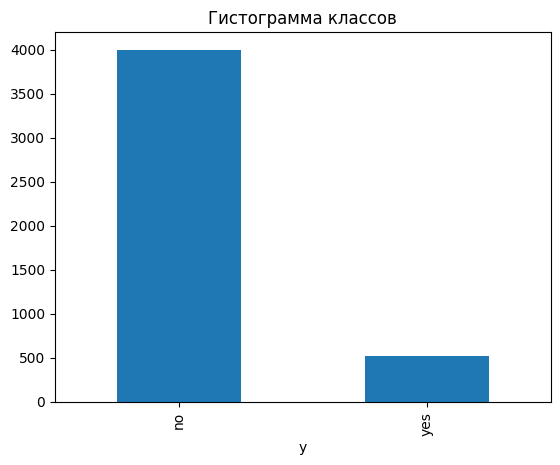

In [6]:
pd.value_counts(data['y']).plot.bar()
plt.title('Гистограмма классов')
plt.show()

# Анализ данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


Обращаем внимание на object! Нам они не подходят, надо будет переделывать тип.

In [8]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [9]:
data.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,4521,4521,4521,4521,4521,4521,4521,4521,4521,4521
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,yes,no,cellular,may,unknown,no
freq,969,2797,2306,4445,2559,3830,2896,1398,3705,4000


In [10]:
# делаем список только категориальных данных
cat_cols = data.describe(include='object').columns.to_list()
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [11]:
cat_data = data[cat_cols]
cat_data.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no
1,services,married,secondary,no,yes,yes,cellular,may,failure,no
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no


In [12]:
# перекодируем категориальные признаки
le = LabelEncoder()

for i in cat_cols:
  cat_data[i + '_LE'] = le.fit_transform(cat_data[i])

cat_data.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y,job_LE,marital_LE,education_LE,default_LE,housing_LE,loan_LE,contact_LE,month_LE,poutcome_LE,y_LE
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no,10,1,0,0,0,0,0,10,3,0
1,services,married,secondary,no,yes,yes,cellular,may,failure,no,7,1,1,0,1,1,0,8,0,0
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no,4,2,2,0,1,0,0,0,0,0
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no,4,1,2,0,1,1,2,6,3,0
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no,1,1,1,0,1,0,2,8,3,0


In [13]:
# удаляем категориальные признаки в их изначальном виде
cat_data_clean = cat_data.drop(cat_cols, axis=1)
cat_data_clean.head()

,job_LE,marital_LE,education_LE,default_LE,housing_LE,loan_LE,contact_LE,month_LE,poutcome_LE,y_LE
0,10,1,0,0,0,0,0,10,3,0
1,7,1,1,0,1,1,0,8,0,0
2,4,2,2,0,1,0,0,0,0,0
3,4,1,2,0,1,1,2,6,3,0
4,1,1,1,0,1,0,2,8,3,0


In [14]:
# сделали датафрейм только с числовыми признаками
num_cols = data.describe().columns.to_list()
num_data = data[num_cols]
num_data.head()

,age,balance,day,duration,campaign,pdays,previous
0,30,1787,19,79,1,-1,0
1,33,4789,11,220,1,339,4
2,35,1350,16,185,1,330,1
3,30,1476,3,199,4,-1,0
4,59,0,5,226,1,-1,0


In [15]:
# объединили числовые признаки с откодированными категориальными
dataset = pd.concat([num_data, cat_data_clean], axis=1)
dataset.head()

,age,balance,day,duration,campaign,pdays,previous,job_LE,marital_LE,education_LE,default_LE,housing_LE,loan_LE,contact_LE,month_LE,poutcome_LE,y_LE
0,30,1787,19,79,1,-1,0,10,1,0,0,0,0,0,10,3,0
1,33,4789,11,220,1,339,4,7,1,1,0,1,1,0,8,0,0
2,35,1350,16,185,1,330,1,4,2,2,0,1,0,0,0,0,0
3,30,1476,3,199,4,-1,0,4,1,2,0,1,1,2,6,3,0
4,59,0,5,226,1,-1,0,1,1,1,0,1,0,2,8,3,0


In [16]:
# избавились от типа object
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   age           4521 non-null   int64
 1   balance       4521 non-null   int64
 2   day           4521 non-null   int64
 3   duration      4521 non-null   int64
 4   campaign      4521 non-null   int64
 5   pdays         4521 non-null   int64
 6   previous      4521 non-null   int64
 7   job_LE        4521 non-null   int64
 8   marital_LE    4521 non-null   int64
 9   education_LE  4521 non-null   int64
 10  default_LE    4521 non-null   int64
 11  housing_LE    4521 non-null   int64
 12  loan_LE       4521 non-null   int64
 13  contact_LE    4521 non-null   int64
 14  month_LE      4521 non-null   int64
 15  poutcome_LE   4521 non-null   int64
 16  y_LE          4521 non-null   int64
dtypes: int64(17)
memory usage: 600.6 KB


In [17]:
y = np.array(dataset['y_LE'])
X = np.array(dataset.drop('y_LE', axis=1))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3616, 16)
(905, 16)
(3616,)
(905,)


In [19]:
kNN = KNeighborsClassifier(n_neighbors=3)

In [20]:
kNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [21]:
y_pred = kNN.predict(X_test)

In [22]:
y_pred[:20]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [23]:
# значение метрики отвратительное (<0.5). это потому что у нас разбалансированная выборка 
print(f'f1 = {f1_score(y_test, y_pred):.4f}')

f1 = 0.3571


# Выбор метода балансировки

In [24]:
# 1. Определение методов балансировки
methods = {
    'NearMiss1': NearMiss(version=1),  # Используем NearMiss-1
    'NearMiss2': NearMiss(version=2),  # Используем NearMiss-2
    'NearMiss3': NearMiss(version=3),  # Используем NearMiss-3
    'RUS': RandomUnderSampler(sampling_strategy = 'majority'),
    'SMOTE': SMOTE(sampling_strategy='minority'),
}

# 2. Кросс-валидация для оценки производительности
results = {}

for method_name, method in methods.items():
  X_balance, y_balance = method.fit_resample(X, y)
  # Оценка модели с использованием кросс-валидации 
  # cv= 5 указывает на сколько фолдов мы разбиваем выборку
  f1_scores = cross_val_score(kNN, X_balance, y_balance, cv=5, scoring=make_scorer(f1_score))
  recall_scores = cross_val_score(kNN, X_balance, y_balance, cv=5, scoring=make_scorer(recall_score))
  results[method_name] = [f1_scores.mean(), recall_scores.mean()]

# 3. Вывод результатов
for method_name, score in results.items():
    print(f"{method_name}: F1 Score = {score[0]:.4f},  Recall = {score[1]:.4f}")


NearMiss1: F1 Score = 0.8623,  Recall = 0.8466
NearMiss2: F1 Score = 0.6808,  Recall = 0.8791
NearMiss3: F1 Score = 0.5468,  Recall = 0.5971
RUS: F1 Score = 0.7162,  Recall = 0.7103
SMOTE: F1 Score = 0.8790,  Recall = 0.9455


Среди всех методов балансировки для нашей модели лучшим оказался метод SMOTE

Но NearMiss1 тоже хорошо себя показал + он не дает разрастания выборки, как это делает SMOTE

# Подбор гиперпараметров методом сетки

In [25]:
# Создание пайплайна (конвейера) 
# позволяет объединить несколько шагов - обработка данных и обучение сразу 
# подается список кортежей ('идентификатор' и объект)
pipeline = Pipeline([
    ('scaler', StandardScaler()), #для стандартизации признаков 
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__metric': ['euclidean', 'manhattan']
    }

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy') # accuracy, recall, f1, precision
grid_search.fit(X_balance, y_balance)
print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучшая точность: {grid_search.best_score_}')

Лучшие параметры: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
Лучшая точность: 0.915875


# ML - classification

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6400, 16)
(1600, 16)
(6400,)
(1600,)


In [27]:
kNN = KNeighborsClassifier(n_neighbors=3, metric='manhattan')

In [28]:
kNN.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3)

In [29]:
y_pred = kNN.predict(X_test)

In [30]:
model_list =[kNN]
model_name_list = ['kNN']

def get_metrics(model_list,
                model_name_list,
                X_test, y_test
                ):
  for i in range(len(model_list)):
    y_pred = model_list[i].predict(X_test)
    print(f'для модели {model_name_list[i]}')
    print('Confisuion matrix = ')
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy = {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision_score = {precision_score(y_test, y_pred):.4f}')
    print(f'Recall = {recall_score(y_test, y_pred):.4f}')
    print(f'f1 = {f1_score(y_test, y_pred):.4f}')
    print(f'AUC_ROC = {roc_auc_score(y_test, y_pred):.4f}')

In [31]:
get_metrics(model_list, model_name_list, X_test, y_test)

для модели kNN
Confisuion matrix = 
[[637 164]
 [ 31 768]]
Accuracy = 0.8781
Precision_score = 0.8240
Recall = 0.9612
f1 = 0.8873
AUC_ROC = 0.8782


После балансировки данных видим более высокое значение метрики f1 score, остальные метрики тоже показали хороший результат